In [582]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [583]:
sign_train = pd.read_csv("sign_mnist_train.csv")
sign_test = pd.read_csv("sign_mnist_test.csv")
sign_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [584]:
sign_train.shape

(27455, 785)

## Data Preprocessing

In [585]:
y = sign_train.label
y_test = sign_test.label
y.shape, y_test.shape

((27455,), (7172,))

In [586]:
sign_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [587]:
train_images = sign_train.iloc[:, 1:].values.reshape(-1, 28, 28)
test_images = sign_test.iloc[:, 1:].values.reshape(-1, 28, 28)

In [588]:
train_images.shape, test_images.shape


((27455, 28, 28), (7172, 28, 28))

In [589]:
def plot_images(data):
    selected_index = np.random.choice(data.shape[0], 10, replace=True)
    fig, axes = plt.subplots(2,5, figsize=(7, 5))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(train_images[selected_index][i],  cmap='gray', interpolation='bicubic')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

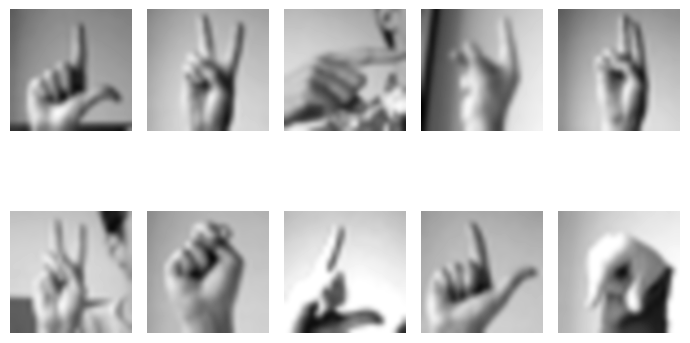

In [590]:
plot_images(test_images)

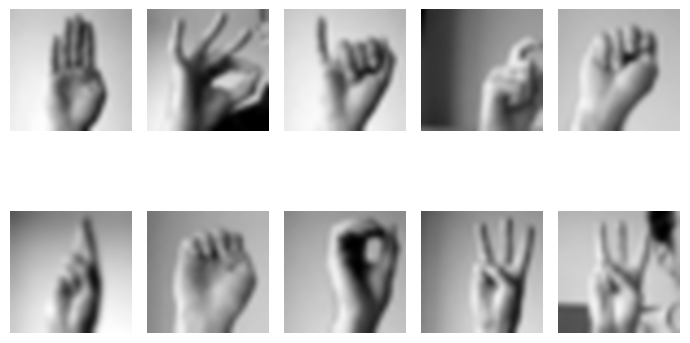

In [591]:
plot_images(train_images)

In [592]:
y.nunique()

24

In [593]:
X_train, X_val, y_train, y_val = train_test_split(train_images, y, test_size=0.1, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((24709, 28, 28), (24709,), (2746, 28, 28), (2746,))

In [594]:
X_train_normalised = X_train/255
X_val_normalised = X_val/255
X_test_normalised = test_images/255

In [595]:
# def preprocessing(data):
#     flattened_images = data.reshape(data.shape[0], -1)
#     normalised_images = flattened_images/255
#     return normalised_images
# X_train_normalised = preprocessing(X_train)
# X_val_normalised = preprocessing(X_val)
# X_test_normalised = preprocessing(test_images)
# X_train_normalised.shape, X_val_normalised.shape

In [596]:
map_labels = lambda label: label-1 if label > 9 else label

In [598]:
if 'y_test_original' not in globals():
    y_train_original = y_train.copy()
    y_val_original = y_val.copy()
    y_test_original = y_test.copy()
    
    
y_train = y_train_original.apply(map_labels)
y_val  = y_val_original.apply(map_labels)
y_test = y_test_original.apply(map_labels)

y_test

0        6
1        5
2        9
3        0
4        3
        ..
7167     1
7168    11
7169     2
7170     4
7171     2
Name: label, Length: 7172, dtype: int64

In [599]:
y_train_encoded = to_categorical(y_train, num_classes=24)
y_val_encoded = to_categorical(y_val, num_classes=24)
y_test_encoded = to_categorical(y_test, num_classes=24)
y_train.nunique()

24

In [600]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('final_model.hdf5', monitor='val_loss', save_best_only=True)


In [601]:
datagen = ImageDataGenerator(
                   rotation_range=10,
                   width_shift_range=0.0,
                   height_shift_range=0.1,
                   zoom_range=0.1
                   )
train_generator = datagen.flow(X_train_normalised.reshape(-1, 28, 28, 1), y_train_encoded, batch_size=32, shuffle=False)

In [602]:
def create_ann_model(model=None, input_shape=(28, 28, 1)):
    if model is None:
        model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(24, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
ann_model = create_ann_model()
ann_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 128)               100480    
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 50)                6450      
                                                                 
 dropout_61 (Dropout)        (None, 50)                0         
                                                                 
 dense_62 (Dense)            (None, 24)                1224      
                                                                 
Total params: 108154 (422.48 KB)
Trainable params: 10

In [603]:
for images, label in train_generator:
    print(images.shape)
    print(label.shape)
    break;

(32, 28, 28, 1)
(32, 24)


In [604]:
non_augmented_ann_model = create_ann_model()
ann_history_non_augmented = non_augmented_ann_model.fit(X_train_normalised.reshape(-1, 28, 28, 1), y_train_encoded, 
                                                        validation_data=(X_val_normalised.reshape(-1, 28, 28, 1), y_val_encoded), 
                                                        epochs=5, callbacks=[early_stopping])

Epoch 1/5
773/773 [==============================] - 4s 4ms/step - loss: 3.1811 - accuracy: 0.0450 - val_loss: 3.1757 - val_accuracy: 0.0470
Epoch 2/5
773/773 [==============================] - 3s 4ms/step - loss: 3.1758 - accuracy: 0.0472 - val_loss: 3.1756 - val_accuracy: 0.0470
Epoch 3/5
773/773 [==============================] - 3s 4ms/step - loss: 3.1760 - accuracy: 0.0463 - val_loss: 3.1755 - val_accuracy: 0.0470
Epoch 4/5
773/773 [==============================] - 3s 4ms/step - loss: 3.1403 - accuracy: 0.0550 - val_loss: 3.0525 - val_accuracy: 0.0808
Epoch 5/5
773/773 [==============================] - 3s 4ms/step - loss: 3.0991 - accuracy: 0.0612 - val_loss: 3.0117 - val_accuracy: 0.0965


In [605]:
non_augmented_ann_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 1s 3ms/step - loss: 3.0767 - accuracy: 0.0513


[3.0767438411712646, 0.05131065100431442]

In [606]:
augmented_ann_model = create_ann_model()
ann_history_augmented = augmented_ann_model.fit(train_generator, 
                                                validation_data=(X_val_normalised.reshape(-1, 28,28, 1), y_val_encoded), 
                                                epochs=5, callbacks=[early_stopping])

Epoch 1/5
773/773 [==============================] - 11s 12ms/step - loss: 3.1821 - accuracy: 0.0444 - val_loss: 3.1759 - val_accuracy: 0.0470
Epoch 2/5
773/773 [==============================] - 9s 12ms/step - loss: 3.1761 - accuracy: 0.0464 - val_loss: 3.1756 - val_accuracy: 0.0470
Epoch 3/5
773/773 [==============================] - 9s 11ms/step - loss: 3.1759 - accuracy: 0.0464 - val_loss: 3.1755 - val_accuracy: 0.0470
Epoch 4/5
773/773 [==============================] - 9s 11ms/step - loss: 3.1759 - accuracy: 0.0469 - val_loss: 3.1755 - val_accuracy: 0.0470
Epoch 5/5
773/773 [==============================] - 9s 12ms/step - loss: 3.1758 - accuracy: 0.0461 - val_loss: 3.1755 - val_accuracy: 0.0470


In [237]:
non_augmented_ann_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 1s 3ms/step - loss: 3.1721 - accuracy: 0.0000e+00


[3.172062635421753, 0.0]

In [239]:
X_test_normalised.shape

(7172, 28, 28)

In [617]:
def create_cnn_model(model=None, input_shape=(28,28,1)):
    if model is None:
        model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model.add(Dropout(0.2))



    model.add(Flatten())

    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=24, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_72 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_29 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_73 (Dropout)        (None, 7, 7, 64)        

In [222]:
non_augmented_cnn_model = create_cnn_model()
cnn_history_non_augmented = non_augmented_cnn_model.fit(x=X_train_normalised.reshape(-1, 28, 28, 1), y=y_train_encoded, 
                                                        epochs=5, validation_data=(X_val_normalised.reshape(-1, 28, 28, 1), y_val_encoded), 
                                                        callbacks=[early_stopping])

Epoch 1/5
773/773 [==============================] - 18s 22ms/step - loss: 1.3574 - accuracy: 0.5769 - val_loss: 0.2327 - val_accuracy: 0.9395
Epoch 2/5
773/773 [==============================] - 16s 21ms/step - loss: 0.2490 - accuracy: 0.9173 - val_loss: 0.0451 - val_accuracy: 0.9967
Epoch 3/5
773/773 [==============================] - 18s 23ms/step - loss: 0.1090 - accuracy: 0.9641 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 4/5
773/773 [==============================] - 17s 21ms/step - loss: 0.0663 - accuracy: 0.9788 - val_loss: 0.0072 - val_accuracy: 0.9996
Epoch 5/5
773/773 [==============================] - 16s 21ms/step - loss: 0.0461 - accuracy: 0.9850 - val_loss: 0.0044 - val_accuracy: 0.9996


In [607]:
non_augmented_cnn_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 2s 7ms/step - loss: 0.2821 - accuracy: 0.9228


[0.28207826614379883, 0.9227551817893982]

In [618]:
augmented_cnn_model = create_cnn_model()
cnn_history_augmented = augmented_cnn_model.fit(train_generator, epochs=20, 
              validation_data=(X_val_normalised.reshape(-1, 28, 28, 1), y_val_encoded), 
              callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
773/773 [==============================] - 30s 37ms/step - loss: 2.3943 - accuracy: 0.2486 - val_loss: 0.7888 - val_accuracy: 0.7487
Epoch 2/20
773/773 [==============================] - 28s 36ms/step - loss: 0.8561 - accuracy: 0.7018 - val_loss: 0.2109 - val_accuracy: 0.9494
Epoch 3/20
773/773 [==============================] - 28s 37ms/step - loss: 0.5082 - accuracy: 0.8209 - val_loss: 0.0957 - val_accuracy: 0.9734
Epoch 4/20
773/773 [==============================] - 28s 37ms/step - loss: 0.3668 - accuracy: 0.8709 - val_loss: 0.0504 - val_accuracy: 0.9880
Epoch 5/20
773/773 [==============================] - 28s 36ms/step - loss: 0.2840 - accuracy: 0.9032 - val_loss: 0.0302 - val_accuracy: 0.9938
Epoch 6/20
773/773 [==============================] - 38s 49ms/step - loss: 0.2371 - accuracy: 0.9197 - val_loss: 0.0239 - val_accuracy: 0.9978
Epoch 7/20
773/773 [==============================] - 38s 48ms/step - loss: 0.2159 - accuracy: 0.9281 - val_loss: 0.0142 - val_accuracy:

In [608]:
augmented_cnn_model.evaluate(x=X_test_normalised.reshape(-1, 28, 28, 1), y=y_test_encoded)

225/225 [==============================] - 2s 7ms/step - loss: 0.0295 - accuracy: 0.9886


[0.02946634590625763, 0.9885666370391846]

In [609]:
import copy
history = copy.deepcopy(cnn_history_augmented)
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

def plot_accuracy(acc, val_acc, loss, val_loss):
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax[0].plot(acc, label='train')
    ax[0].plot(val_acc, label='validation')
    ax[1].plot(loss, label='train')
    ax[1].plot(val_loss, label='validation')
    ax[0].set_ylabel('accuracy')
    ax[1].set_ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

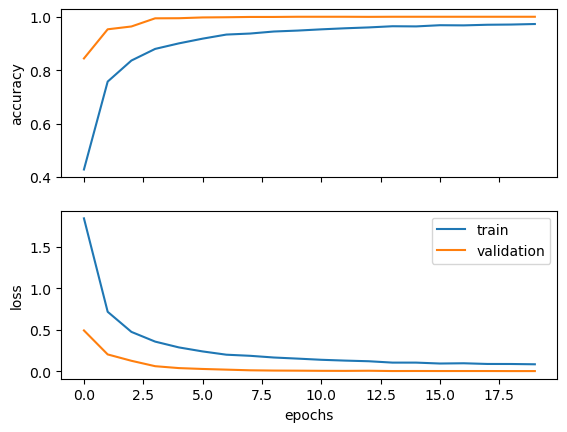

In [610]:
plot_accuracy(acc, val_acc, loss, val_loss)

In [611]:
predictions = augmented_cnn_model.predict(X_test_normalised.reshape(-1, 28, 28, 1))
predicted_labels = [np.argmax(i) for i in predictions]
predicted_labels[:5]

225/225 [==============================] - 2s 7ms/step


[6, 5, 9, 0, 3]

In [612]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      0.95      0.97       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       0.95      1.00      0.97       209
          11       0.97      1.00      0.99       394
          12       1.00      0.96      0.98       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.89      1.00      0.94       144
          17       0.99    

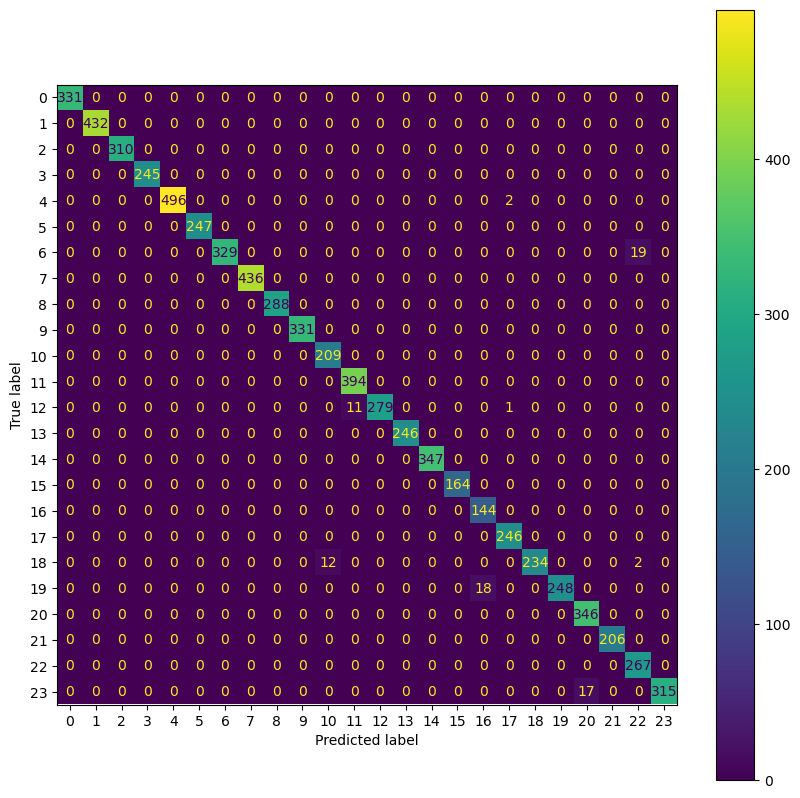

In [614]:
fig, ax = plt.subplots(figsize=(10,10))

matrix_plot = confusion_matrix(y_test, predicted_labels)

disp = ConfusionMatrixDisplay(matrix_plot)
disp.plot(ax=ax)
